In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import sparse as sp
from PIL import Image
import cv2

Lecture de l'image et bruitage

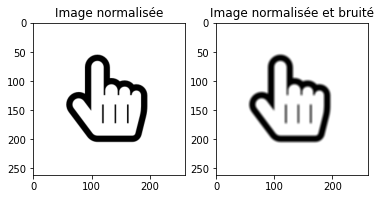

In [2]:
I = cv2.imread("im6.png",0)
In = cv2.normalize(I,None,0,1.0,cv2.NORM_MINMAX,dtype=cv2.CV_32F)
Element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(40,40))
Ib = cv2.GaussianBlur(In,(5,5),cv2.BORDER_DEFAULT)

Iaffiche = np.copy(In)
In = Ib

plt.figure()
plt.subplot(121)
plt.title("Image normalisée")
plt.imshow(Iaffiche,'gray') # affichage de l'image I en niveau de gris

plt.subplot(122)
plt.title("Image normalisée et bruité")
plt.imshow(In,'gray') # affichage de l'image I en niveau de gris
plt.show()

Initialisation de notre snake 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


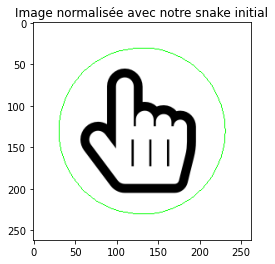

In [3]:
y,x = np.shape(I)
K = 100
cercle = np.zeros([2,K])
centreX = int(x/2)
centreY = int(y/2)
rayon = 100
theta = 0

c = list()
cc = np.zeros((K,1,2))

for i, angle in enumerate(np.linspace(0,2*np.pi,K)):
    cercle[0,i] = centreX + rayon*np.cos(angle)
    cercle[1,i] = centreY + rayon*np.sin(angle)
    

cc[:,0,0] = cercle[0,:]
cc[:,0,1] = cercle[1,:]
c.append(cc.astype(int))

IC = cv2.drawContours(image=cv2.cvtColor(Iaffiche,cv2.COLOR_GRAY2BGR),contours=c,contourIdx=len(c) -1,color=(0,255,0),thickness=1,lineType=cv2.LINE_AA)

plt.figure()
plt.title("Image normalisée avec notre snake initial")
plt.imshow(IC,'gray') # affichage de l'image I en niveau de gris
plt.show()
    

Initialisation de l'algorithme

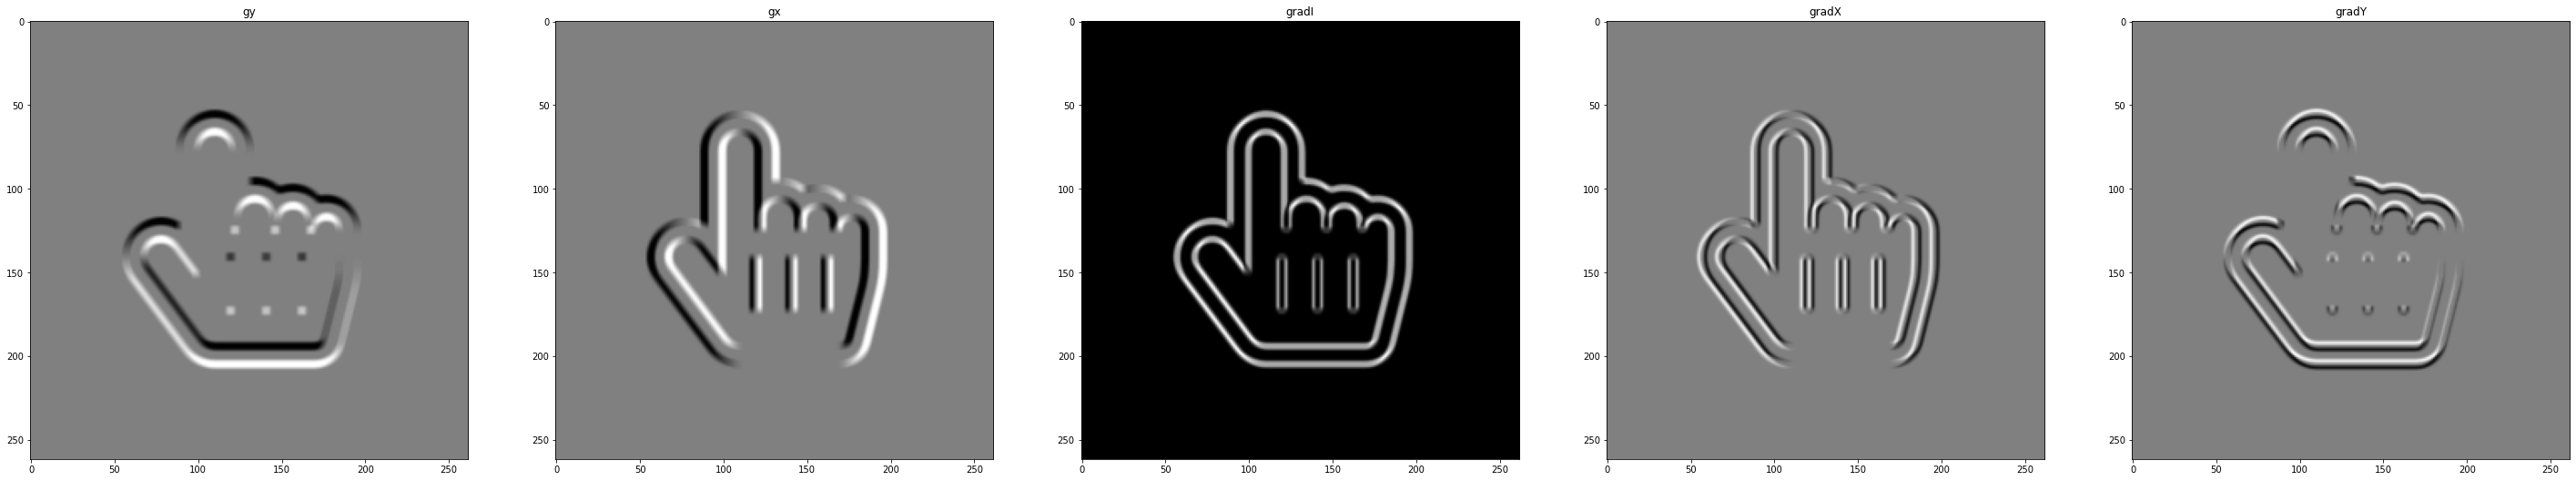

In [4]:
alpha = 0.15 #poid de l'energie elastique
beta = 0.1 #poid de l'energie de courbure
gamma = 35 #poid de l'energie de l'image
deltaT = 0.5 #pas temporel

D1 = sp.diags([1,-1],[0,-1],shape=(K,K)).toarray()
D1[0,K-1] = -1
#Opérateur différentiel
D2 =sp.diags([1,-2,1],[-1,0,1],shape=(K,K)).toarray()
D2[0,K-1] = 1
D2[K-1,0] = 1
D4 =sp.diags([1,-4,6,-4,1],[-2,-1,0,1,2],shape=(K,K)).toarray()
D4[1,K-1] = 1
D4[K-1,1] = 1
D4[0,K-2] = 1
D4[K-2,0] = 1
D4[0,K-1] = -4
D4[K-1,0] = -4

D = alpha*D2 - beta*D4
A = np.linalg.inv(np.eye(K,K)-deltaT*D)

#Gradient
gy, gx = np.gradient(In)
gradI = gx**2+gy**2
gradY,gradX = np.gradient(gradI)

plt.figure(figsize=(50,10))
plt.subplot(151)
plt.title("gy")
plt.imshow(gy,'gray') # affichage de l'image I en niveau de gris

plt.subplot(152)
plt.title("gx")
plt.imshow(gx,'gray') # affichage de l'image I en niveau de gris

plt.subplot(153)
plt.title("gradI")
plt.imshow(gradI,'gray') # affichage de l'image I en niveau de gris

plt.subplot(154)
plt.title("gradX")
plt.imshow(gradX,'gray') # affichage de l'image I en niveau de gris

plt.subplot(155)
plt.title("gradY")
plt.imshow(gradY,'gray') # affichage de l'image I en niveau de gris
plt.show()

#Condition d'arrêt : lorsque norm(xn+1-xn)<epsilon on va prendre pr tester en premier epison = 10**-3

Implémentation de la procédure itérative

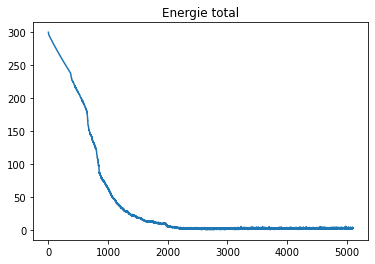

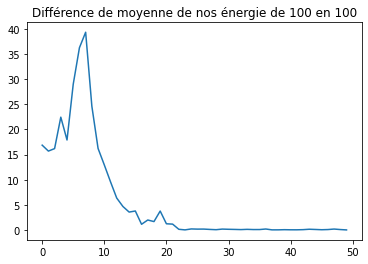

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


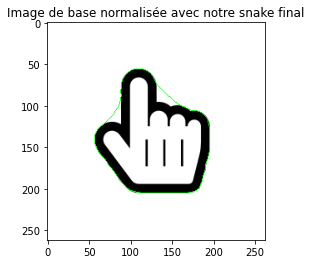

In [5]:
epsilon = 10**-5

xn2 = cc[:,0,0]
xn1 = cc[:,0,0]
yn2 = cc[:,0,1]
yn1 = cc[:,0,1]

test1 = 1
test2 = 1
cpt = 0
EnergieTotalPlot = []
EnergieYPlot = []
EnergieXPlot = []
energieTotal = 1
DiffEnergiePlot = []
e1 = 0
e2 = 0
moy = []
dif = 100
#(energieTotal>-50 ) and
while  dif>0.01 :
    cpt+=1
    xn1 = xn2
    yn1 = yn2
    xn2 = np.dot(A,(xn1+deltaT*gamma*gradX[yn1.astype(int),xn1.astype(int)]))
    yn2 = np.dot(A,(yn1+deltaT*gamma*gradY[yn1.astype(int),xn1.astype(int)]))
    
    energieX = 0.5*alpha*np.dot(np.transpose(np.dot(D1,xn2)),np.dot(D1,xn2)) + 0.5*beta*np.dot(np.transpose(np.dot(D2,xn2)),np.dot(D2,xn2)) - gamma*np.dot(np.transpose(gx[yn2.astype(int),xn2.astype(int)]),gx[yn2.astype(int),xn2.astype(int)])
    energieY = 0.5*alpha*np.dot(np.transpose(np.dot(D1,yn2)),np.dot(D1,yn2)) + 0.5*beta*np.dot(np.transpose(np.dot(D2,yn2)),np.dot(D2,yn2)) - gamma*np.dot(np.transpose(gy[yn2.astype(int),xn2.astype(int)]),gy[yn2.astype(int),xn2.astype(int)])
    energieTotal = energieX+energieY
    moy.append(energieTotal)
    if len(moy)==100:
        e1 = e2
        e2 = np.mean(moy)
        if e1!=0:
            dif = np.abs(e2-e1)
            DiffEnergiePlot.append(dif)
        moy = []
    EnergieTotalPlot.append(energieX+energieY)
    EnergieYPlot.append(energieY)
    EnergieXPlot.append(energieX)
        

plt.plot(EnergieTotalPlot)
plt.title("Energie total")
plt.show()
plt.plot(DiffEnergiePlot)
plt.title("Différence de moyenne de nos énergie de 100 en 100")
plt.show()


cc[:,0,0] = xn2
cc[:,0,1] = yn2
c = list()

c.append(cc.astype(int))

IC = cv2.drawContours(image=cv2.cvtColor(Iaffiche,cv2.COLOR_GRAY2BGR),contours=c,contourIdx=len(c) -1,color=(0,255,0),thickness=1,lineType=cv2.LINE_AA)

plt.figure()
plt.title("Image de base normalisée avec notre snake final")
plt.imshow(IC,'gray') # affichage de l'image I en niveau de gris
plt.show()